# Poisson equation in a multi-patch domain

In [1]:
%matplotlib inline

import numpy as np
import scipy
import matplotlib.pyplot as plt
import itertools

np.set_printoptions(linewidth=100000)

from pyiga import bspline, assemble, vform, geometry, vis, solvers, topology, adaptive
from pyiga import assemble_cy

In [2]:
# define discretization space (we may choose nested discretization spaces)
p = 3
N = 10
kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),),
       2 * (bspline.make_knots(p, 0.0, 1.0, N),),
       2 * (bspline.make_knots(p, 0.0, 1.0, N),),
       2 * (bspline.make_knots(p, 0.0, 1.0, N),)]

In [3]:
# define geometry
geos = [
    geometry.quarter_annulus(),
    geometry.unit_square().translate((-1, 1)),
    geometry.quarter_annulus().rotate_2d(np.pi).translate((-1, 3)),
    geometry.quarter_annulus().rotate_2d(-np.pi/2).translate((-2, 1))
]

patches = [(kv, g) for kv,g in zip(kvs,geos)]

In [4]:
def bounding_box_distance(bb1, bb2):
    # bb1, bb2: list of (min, max) intervals for each dim
    dist2 = 0.0
    for (lo1, hi1), (lo2, hi2) in zip(bb1, bb2):
        if hi1 < lo2:
            dist2 += (lo2 - hi1) ** 2
        elif hi2 < lo1:
            dist2 += (lo1 - hi2) ** 2
    return dist2 ** 0.5

def bounding_box_diameter(bb):
    return sum((hi - lo) ** 2 for lo, hi in bb) ** 0.5
    
def _check_geo_match(G1, G2, grid=4, tol=1e-10):
    if G1.sdim != G2.sdim or G1.dim != G2.dim:
        return False, (None, None)
    if not np.allclose(G1.support, G2.support, atol=tol):
        return False, (None, None)

    grid_pts = [np.linspace(s[0], s[1], grid) for s in G1.support]
    X1 = G1.grid_eval(grid_pts)

    for perm in itertools.permutations(range(G1.sdim)):
        for flip in itertools.product(*[(False, True)] * G2.sdim):
            flipped_grid = [np.flip(ax) if f else ax
                            for ax, f in zip(grid_pts, flip)]
            X2 = G2.grid_eval(flipped_grid).transpose(perm + (G2.sdim,))
            if np.allclose(X1, X2, atol=tol):
                return True, (perm, flip)

    return False, (None, None)

def _find_matching_boundaries(G1, G2, grid=4, tol=1e-10):
    assert G1.sdim == G2.sdim and G1.dim == G2.dim
    matches = []
    for b1 in range(2 * G1.sdim):
        bd1 = G1.boundary(b1)
        for b2 in range(2 * G1.sdim):
            bd2 = G2.boundary(b2)
            match, conn_info = _check_geo_match(bd1, bd2, grid=grid, tol=tol)
            if match:
                matches.append((b1, b2, conn_info))
    return matches

def detect_interfaces(patches, grid=4, tol=1e-10):
    import networkx as nx

    interfaces = []
    patch_graph = nx.Graph()
    patch_graph.add_nodes_from(range(len(patches)))

    # Precompute bounding boxes and diameters
    bbs = [geo.bounding_box() for _, geo in patches]
    diams = [bounding_box_diameter(bb) for bb in bbs]

    for p1, (_, G1) in enumerate(patches):
        for p2 in range(p1 + 1, len(patches)):
            bb1, bb2 = bbs[p1], bbs[p2]
            mindist = bounding_box_distance(bb1, bb2)
            maxdiam = max(diams[p1], diams[p2])

            # Only consider pairs whose bounding boxes touch (allow small tol)
            if mindist < 1e-10 * maxdiam:
                matches = _find_matching_boundaries(G1, patches[p2][1], grid=grid, tol=tol)
                for bd1, bd2, conn_info in matches:
                    interfaces.append((p1, bd1, p2, bd2, conn_info))
                if matches:
                    patch_graph.add_edge(p1, p2)

    return nx.is_connected(patch_graph), interfaces

In [5]:
assemble.detect_interfaces(patches)

(True,
 [(0, 1, 1, 3, ((np.int64(0),), (False,))),
  (1, 2, 2, 1, ((np.int64(0),), (True,))),
  (1, 0, 3, 1, ((np.int64(0),), (False,)))])

In [13]:
# source term f and Dirichlet boundary function g
f  = lambda x, y: np.exp(-5 * ((x-0.3)**2 + (y-1)**2))
gD = lambda x, y: 1e-1 * np.sin(8*x)

# Robin boundary data such that \partial_n u + alpha * u = g1, if alpha=0 this represents also a Neumann boundary condition.
gN = lambda x, y: 0.
alpha = lambda x, y: 0.

# set up a PatchMesh object, which detects interfaces between patches
M = topology.PatchMesh(patches)

# by default all outer boundaries are given the index 0, which we will use for the Dirichlet boundary
# let us generate a Neumann boundary indexed by 1
M.set_boundary_id({'Neumann/Robin':{(0,'left'),(2,'right'),(3,'left'),(3,'right')},
                   'Dirichlet':{(0,'bottom'),(0,'right'),(1,'top'),(2,'bottom'),(2,'left'),(3,'bottom')}})

# set up a MultiPatch object that initializes a Basis to map global dofs to local dofs
MP = assemble.Multipatch(M, automatch=True)

# set Dirichlet values for DoFs at the Dirichlet boundary
dir_bcs = MP.set_dirichlet_boundary({'Dirichlet':gD})

# assemble the linear system and (possible) Neumann vector or Robin matrix/vector
Kh = MP.assemble_volume("inner(grad(u), grad(v)) * dx", arity = 2)
Fh = MP.assemble_volume("f * v * dx", arity=1, physical=True, f=f) #f is living in the physical domain

# generate Neumann vector for global contribution to the right hand side, in this case it is a zero vector since g1 is zero
Nh = MP.assemble_surface('(gN * v) * ds', arity=1, gN=gN, boundary_idx='Neumann/Robin')

# generate Robin Matrix for global contribution to the right hand side, in this case it is a zero matrix again since alpha is zero
Rh = MP.assemble_surface('(alpha * u * v) * ds', arity=2, alpha=alpha, boundary_idx='Neumann/Robin')

setting up constraints took 0.0042912960052490234 seconds.
Basis setup took 0.001982450485229492 seconds


TypeError: Unsupported type for bdspec: <class 'list'>

In [10]:
M.interfaces

{(0, 1, 0): ((1, 3, 0), (False,)),
 (1, 3, 0): ((0, 1, 0), (False,)),
 (1, 2, 0): ((2, 1, 0), (True,)),
 (2, 1, 0): ((1, 2, 0), (True,)),
 (1, 0, 0): ((3, 1, 0), (False,)),
 (3, 1, 0): ((1, 0, 0), (False,))}

In [11]:
M.outer_boundaries

{'Neumann/Robin': {(0, 2), (2, 3), (3, 2), (3, 3)},
 'Dirichlet': {(0, 0), (0, 3), (1, 1), (2, 0), (2, 2), (3, 0)}}

In [12]:
MP.Basis

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 676 stored elements and shape (676, 637)>

In [6]:
bspline._parse_bdspec(np.array([0,0]), 2)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

[(1, 1)]
[(1, 0)]
[(1, 1)]
[(1, 0)]
[(1, 0)]
[(0, 0)]
[(0, 1)]
[(1, 1)]
[(0, 0)]
[(0, 0)]


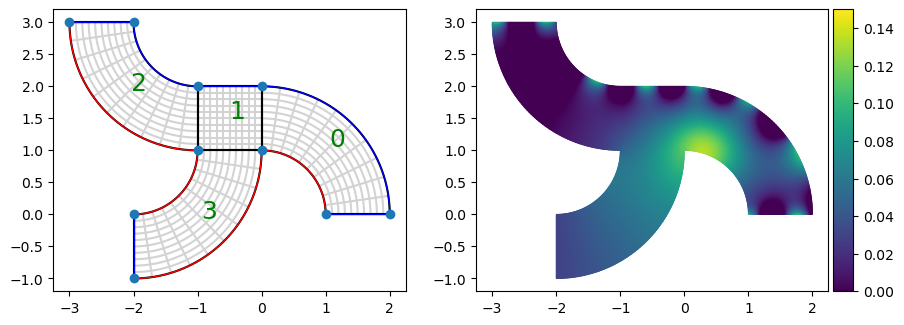

In [5]:
# set up and solve linear system by eliminating Dirichlet DoFs from the system
LS = assemble.RestrictedLinearSystem(Kh + Rh, Fh + Nh, dir_bcs)
u = LS.complete(solvers.make_solver(LS.A, spd=True)@LS.b)

# restrict solution to each individual patch (kvs on every patch) and visualize solution together with the mesh
fig, ax = plt.subplots(1,2,figsize=(10,5))
M.plotmesh(patch_idx = True, knots=True, nodes=True, bcolor={'Dirichlet':'blue','Neumann/Robin':'red'}, axis=ax[0])
MP.plot(u, range = (0, 1.5e-1),cbar=True, cmap='viridis', axis=ax[1], aspect='equal', cbar_width=0.2, cbar_pad = 0.05);
ax[0].axis('scaled'); #ax[1].axis('scaled');

# Computerchip

In [6]:
# define geometry
def ComputerChip(p, N):
    geos = [
        geometry.Quad(np.array([[0,0.5,0.35, 0.5],[0,0,0.3,0.15]])),
        geometry.Quad(np.array([[0, 0.35, 0, 0.17],[0, 0.3, 0.6, 0.6]])),
        geometry.Quad(np.array([[0.35, 0.5, 0.17, 0.5],[0.3, 0.45, 0.6, 0.6]])),
        geometry.Quad(np.array([[0.17, 0.5, 0.17, 0.5],[0.6, 0.6, 0.8, 0.8]])),
        geometry.Quad(np.array([[0.5,1,0.5, 0.65],[0,0,0.15,0.3]])),
        geometry.Quad(np.array([[0.65, 1, 0.83,1],[0.3,0,0.6,0.6]])),
        geometry.Quad(np.array([[0.65, 0.83, 0.5, 0.5],[0.3, 0.6, 0.45, 0.6]])),
        geometry.Quad(np.array([[0.5, 0.83, 0.5, 0.83],[0.6, 0.6, 0.8, 0.8]])),
    ]

    kvs = 8 * [2 * (bspline.make_knots(p, 0.0, 1.0, N),)]
    
    patches = [(kv, g) for kv,g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)
    
    M.set_boundary_id({'Dirichlet':{(0,'top'),(2,'bottom'),(4,'top'),(6,'left')},
                       'Neumann':{(1,'top'),(1,'left'),(3,'top'),(3,'left'),(5,'top'),(5,'right'),(7,'top'),(7,'right')},
                       'Robin' : {(0,'bottom'),(4,'bottom')}})
    M.set_domain_id({0:{0,1,2,4,5,6}, 1:{3,7}})
    return M

((0, 0),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((0, 1),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((1, 1),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((0, 0),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((0, 1),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((1, 1),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((0, 0),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((0, 1),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((1, 1),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((0, 0),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((0, 1),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((1, 1),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((0, 0),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((0, 1),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((1, 1),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)


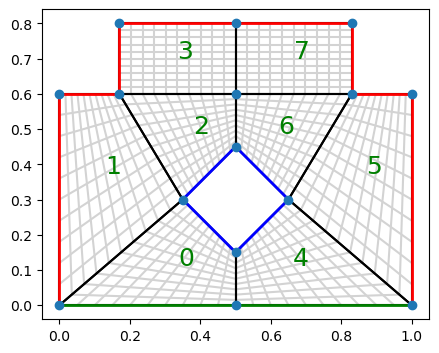

In [7]:
M = ComputerChip(3,10)

# visualize the PatchMesh object with Dirichlet boundary (blue) and Neumann boundary (red)
M.plotmesh(patch_idx = True, knots=True, nodes=True, bcolor={'Dirichlet':'blue','Neumann':'red','Robin':'green'}, bwidth=2)
plt.axis('scaled');

In [8]:
kappa = 130.0
alpha = 0.2
f = lambda x,y: 0.0
gN = lambda x,y: 0.0
gD = lambda x,y: 500.0
gR = lambda x,y: 300.0*alpha
lambda0 = 0.01
lambda1 = 3.95

In [9]:
MP = assemble.Multipatch(M, automatch=True)

# set Dirichlet values for DoFs at the Dirichlet boundary
dir_bcs = MP.set_dirichlet_boundary({'Dirichlet':gD})

# assemble the linear system and (possible) Neumann vector or Robin matrix/vector
Kh = MP.assemble_volume("lambda0 * inner(grad(u), grad(v)) * dx", arity = 2, domain_id=0, lambda0=lambda0) + MP.assemble_volume("lambda1 * inner(grad(u), grad(v)) * dx", arity = 2, domain_id=1, lambda1=lambda1)
Fh = MP.assemble_volume("f * v * dx", arity=1, f=f) #f is living in the physical domain

# generate Neumann vector for global contribution to the right hand side, in this case it is a zero vector since g1 is zero
Nh = MP.assemble_surface('(gN * v) * ds', arity=1, gN=gN, boundary_idx='Neumann')

# generate Robin Matrix for global contribution to the right hand side, in this case it is a zero matrix again since alpha is zero
Rh = MP.assemble_surface('(alpha * u * v) * ds', arity=2, alpha=alpha, boundary_idx='Robin')
Nh += MP.assemble_surface('(gR * v) * ds', arity=1, gR=gR, boundary_idx='Robin')

((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((0, 1),)
((1, 1),)
((0, 1),)
((1, 0),)
((0, 0),)
((1, 0),)
((0, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 0),)
((0, 0),)
((1, 0),)
((0, 0),)
((1, 1),)
((0, 0),)
((1, 1),)
((0, 0),)
((1, 1),)
((0, 0),)
((1, 1),)
((0, 0),)
setting up constraints took 0.021050214767456055 seconds.
Basis setup took 0.0037491321563720703 seconds
[(0, 1)]
[(0, 1)]
[(1, 0)]
[(1, 0)]
[(0, 0)]
[(0, 0)]
[(0, 1)]
[(0, 1)]
[(1, 0)]
[(1, 0)]
[(0, 1)]
[(0, 1)]
[(0, 1)]
[(0, 1)]
[(0, 1)]
[(0, 1)]
[(0, 1)]
[(0, 1)]
[(1, 1)]
[(1, 1)]
[(1, 1)]
[(1, 1)]
[(1, 0)]
[(1, 0)]
[(0, 0)]
[(0, 0)]
[(0, 0)]
[(0, 0)]
[(0, 0)]
[(0, 0)]
[(0, 0)]
[(0, 0)]


In [10]:
LS = assemble.RestrictedLinearSystem(Kh + Rh, Fh + Nh, dir_bcs)
u = LS.complete(solvers.make_solver(LS.A, spd=True)@LS.b)

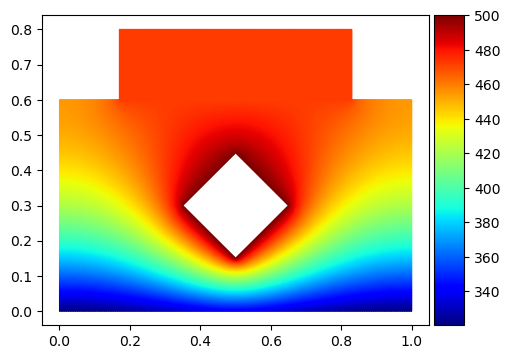

In [11]:
MP.plot(u, cbar=True, cmap='jet', aspect='equal', figsize=(5,5), physical=True);

# Using non-matching multi-patch domains for adaptive refinement

In [12]:
def solveChip(MP):
    Kh = MP.assemble_volume("lambda0 * inner(grad(u), grad(v)) * dx", arity = 2, domain_id=0, lambda0=lambda0) + MP.assemble_volume("lambda1 * inner(grad(u), grad(v)) * dx", arity = 2, domain_id=1, lambda1=lambda1)
    Fh = MP.assemble_volume("f * v * dx", arity=1, f=f) #f is living in the physical domain

    Nh = MP.assemble_surface('(gN * v) * ds', arity=1, gN=gN, boundary_idx='Neumann')
    Rh = MP.assemble_surface('(alpha * u * v) * ds', arity=2, alpha=alpha, boundary_idx='Robin')
    Nh += MP.assemble_surface('(gR * v) * ds', arity=1, gR=gR, boundary_idx='Robin')

    LS = assemble.RestrictedLinearSystem(Kh + Rh, Fh + Nh, dir_bcs)
    return LS.complete(solvers.make_solver(LS.A, spd=True)@LS.b)

((0, 0),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((0, 1),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((1, 1),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((0, 0),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((0, 1),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((1, 1),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((0, 0),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((0, 1),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((1, 1),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((0, 0),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((0, 1),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((1, 1),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((0, 0),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((0, 1),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)
((1, 1),)
((0, 0),)
((0, 1),)
((1, 0),)
((1, 1),)


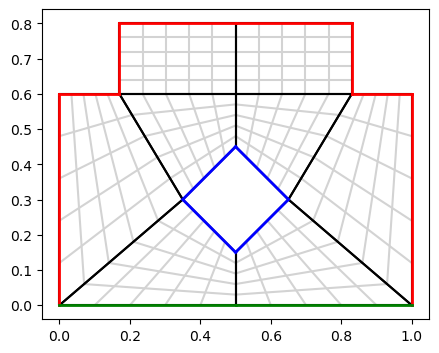

((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((0, 1),)
((1, 1),)
((0, 1),)
((1, 0),)
((0, 0),)
((1, 0),)
((0, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 0),)
((0, 0),)
((1, 0),)
((0, 0),)
((1, 1),)
((0, 0),)
((1, 1),)
((0, 0),)
((1, 1),)
((0, 0),)
((1, 1),)
((0, 0),)
setting up constraints took 0.013732194900512695 seconds.
Basis setup took 0.002175569534301758 seconds
[(0, 1)]
[(0, 1)]
[(1, 0)]
[(1, 0)]
[(0, 0)]
[(0, 0)]
[(0, 1)]
[(0, 1)]
[(1, 0)]
[(1, 0)]
[(0, 1)]
[(0, 1)]
[(0, 1)]
[(0, 1)]
[(0, 1)]
[(0, 1)]
[(0, 1)]
[(0, 1)]
[(1, 1)]
[(1, 1)]
[(1, 1)]
[(1, 1)]
[(1, 0)]
[(1, 0)]
[(0, 0)]
[(0, 0)]
[(0, 0)]
[(0, 0)]
[(0, 0)]
[(0, 0)]
[(0, 0)]
[(0, 0)]
Residual contributions took 0.0582 seconds.
[(1, 1)]
[(1, 0)]
[(1, 0)]
[(1, 1)]
[(1, 0)]
[(1, 1)]
[(0, 1)]
[(0, 1)]
[(1, 1)]
[(0, 1)]
[(1, 0)]
[(0, 0)]
[(0, 0)]
[(1, 0)]
[(0, 0)]
[(1, 1)]
[(1, 0)]
[(1, 0)]
[(1, 1)]
[(1, 0)]
[(0, 1)]
[(0, 0)]
[(0, 0

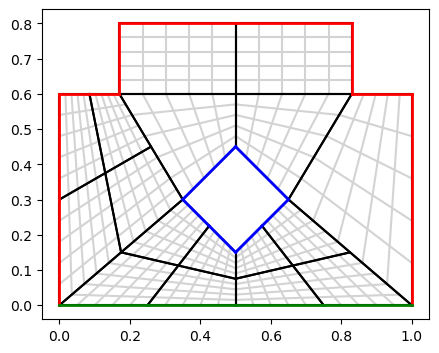

((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((0, 0),)
((1, 1),)
((0, 0),)
((1, 1),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 0),)
((0, 0),)
((1, 0),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 1),)
((0, 0),)
((1, 1),)
((0, 0),)
((1, 1),)
((0, 1),)
((1, 1),)
((0, 1),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 0),)
((0, 0),)
((1, 0),)
((0, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((0, 0),)
((1, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 0),)
((0, 0),)
((1, 0),)
((0, 0),)


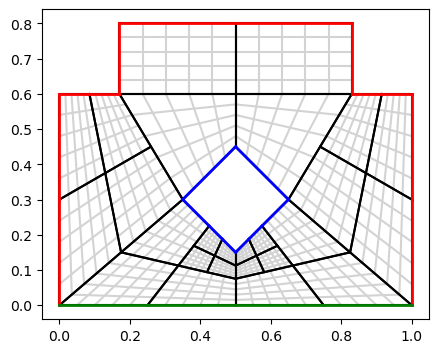

((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 0),)
((1, 1),)
((0, 0),)
((1, 1),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 1),)
((0, 0),)
((1, 1),)
((0, 0),)
((1, 1),)
((0, 0),)
((1, 1),)
((0, 0),)
((1, 1),)
((0, 1),)
((1, 1),)
((0, 1),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 0),)
((0, 0),)
((1, 0),)
((0, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((0, 0),)
((1, 0),)
((0, 0),)
((1, 0),)
((1, 0),)
((0, 0),)
((1, 0),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)


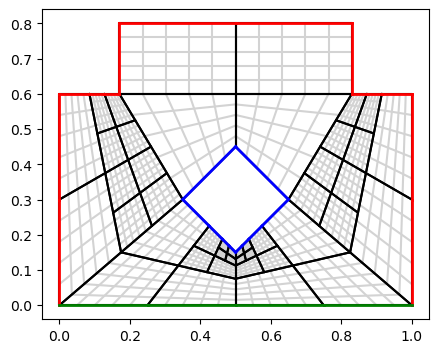

((1, 0),)
((0, 0),)
((1, 0),)
((0, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((0, 0),)
((1, 1),)
((0, 0),)
((1, 1),)
((0, 0),)
((1, 1),)
((0, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 0),)
((0, 0),)
((1, 0),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 0),)
((0, 0),)
((1, 0),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((0, 0),)
((1, 0),)
((0, 0),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)


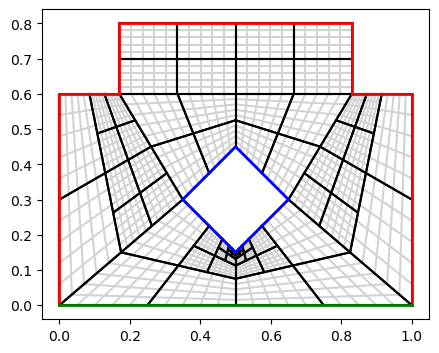

((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((0, 0),)
((1, 1),)
((0, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 0),)
((0, 0),)
((1, 0),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((0, 0),)
((1, 1),)
((0, 0),)
((1, 1),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 0),)
((0, 0),)
((1, 0),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((1, 1),)
((0, 1),)
((1, 1),)
((0, 1),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)


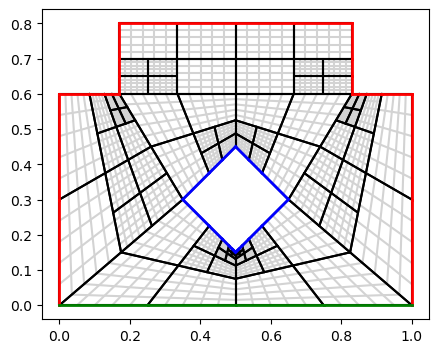

((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 0),)
((0, 0),)
((1, 0),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((0, 0),)
((1, 1),)
((0, 0),)
((1, 1),)
((1, 1),)
((0, 1),)
((1, 1),)
((0, 1),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((1, 1),)
((0, 1),)
((1, 1),)
((0, 1),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((1, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)
((0, 1),)
((0, 0),)
((0, 1),)
((0, 0),)
((1, 0),)
((1, 1),)
((1, 0),)
((1, 1),)


TypeError: cannot unpack non-iterable int object

In [13]:
M = ComputerChip(3,5)

kappa = 130.0
alpha = 0.2
f = lambda x,y: 0.0
gN = lambda x,y: 0.0
gD = lambda x,y: 500.0
gR = lambda x,y: 300.0*alpha
lambda0 = 0.01
lambda1 = 3.95

maxiter=10
for it in range(maxiter):
    M.plotmesh(patch_idx = False, knots=True, nodes=False, bcolor={'Dirichlet':'blue','Neumann':'red','Robin':'green'}, bwidth=2)
    plt.axis('scaled');
    plt.show()

    MP = assemble.Multipatch(M, automatch=True)
    dir_bcs = MP.set_dirichlet_boundary({'Dirichlet':gD})

    #assemble and solve
    u = solveChip(MP)

    #estimate
    err_ind = adaptive.mp_resPois(MP,u,a={0:lambda0, 1:lambda1}, f={0:f, 1:f})

    #mark
    marked_patches = adaptive.quick_mark(err_ind, theta=0.8)

    #refine
    if it != maxiter-1:
        M.h_refine(patches=marked_patches,ref="rs");

In [16]:
M.patches

[(((KnotVector(array([0. , 0. , 0. , 0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.5, 0.5]), 3),
    KnotVector(array([0. , 0. , 0. , 0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.5, 0.5]), 3)),
   <pyiga.bspline.BSplineFunc at 0x7fac4479ae10>),
  [[[np.int64(0), np.int64(20)],
    [22, 23],
    [np.int64(0), np.int64(22)],
    [20, np.int64(23)]],
   [[np.float64(0.0), np.float64(0.5)],
    [np.float64(0.0), np.float64(0.5)],
    [np.float64(0.0), np.float64(0.5)],
    [np.float64(0.0), np.float64(0.5)]]]),
 (((KnotVector(array([0. , 0. , 0. , 0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.5, 0.5]), 3),
    KnotVector(array([0. , 0. , 0. , 0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.5, 0.5]), 3)),
   <pyiga.bspline.BSplineFunc at 0x7fac3c2f8680>),
  [[[np.int64(0), np.int64(22)],
    [25, 26],
    [np.int64(0), np.int64(25)],
    [np.int64(22), np.int64(26)]],
   [[np.float64(0.0), np.float64(0.5)],
    [np.float64(0.0), np.float64(0.5)],
    [np.float64(0.0), np.float64(0.5)],
    [np.float64(0.0), np.float64(0.5)]]])

In [15]:
M.kvs[0][0].support()

(np.float64(0.0), np.float64(0.5))

In [20]:
M.get_vertex_index(np.array([1,0]))

np.int64(10)